In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('./titanic_train.csv', index_col='PassengerId')

In [3]:
data.shape

(891, 11)

In [4]:
data.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

# Убираем лишние признаки, обрабатываем датасет

In [5]:
processed_data = data.copy()
processed_data.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
processed_data.dropna(inplace=True)
processed_data['Sex'] = processed_data['Sex'].map({'male': 1, 'female': 0})

In [6]:
print(processed_data.shape)
processed_data.head()

(714, 7)


Survived  Pclass  Sex   Age  SibSp  Parch     Fare
PassengerId                                                    
1                   0       3    1  22.0      1      0   7.2500
2                   1       1    0  38.0      1      0  71.2833
3                   1       3    0  26.0      0      0   7.9250
4                   1       1    0  35.0      1      0  53.1000
5                   0       3    1  35.0      0      0   8.0500

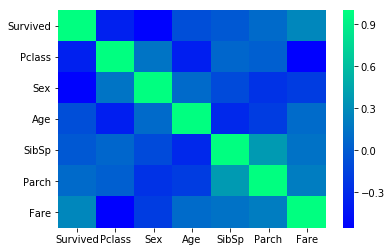

In [7]:
sns.heatmap(
    processed_data.corr(), cmap='winter'
);

# Обучение через дерево решений

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [9]:
x = processed_data.drop('Survived', axis=1)
y = processed_data['Survived']

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=.25, random_state=17)

In [11]:
dt = DecisionTreeClassifier()

In [12]:
tree_params = {
    'max_depth': np.arange(1, 20),
    'max_features': np.arange(1, 11)/10
}

## Predict по CV без настройки

In [48]:
scores = cross_val_score(dt, x_train, y_train, cv=5)
scores.mean(), scores.std()

(0.7326482363160197, 0.017266925289883994)

In [36]:
baseline = 1 - data['Survived'].mean()
baseline

0.6161616161616161

## Predict по CV с подобранными гиперпараметрами

In [37]:
dt_grid = GridSearchCV(dt, tree_params, cv=5, n_jobs=-1)

In [42]:
dt_grid.fit(x_train, y_train);

/home/utoo/.virtualenvs/jupyter_test/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
dt_grid.best_score_, dt_grid.best_params_

(0.8074766355140187, {'max_depth': 11, 'max_features': 0.6})

## Predict отложенной выборки

In [18]:
dt_predict = dt_grid.predict(x_valid)

In [19]:
accuracy_score(y_valid, dt_predict)

0.7486033519553073

# Обучение через метод ближайших соседей

In [20]:
knn = KNeighborsClassifier()

In [21]:
processed_data2 = processed_data.copy()
processed_data2['Male'] = (processed_data2['Sex'] == 1).astype(int)
processed_data2['Female'] = (processed_data2['Sex'] == 0).astype(int)
processed_data2.drop(['SibSp', 'Sex'], axis=1, inplace=True)

In [22]:
processed_data2.head()

Survived  Pclass   Age  Parch     Fare  Male  Female
PassengerId                                                      
1                   0       3  22.0      0   7.2500     1       0
2                   1       1  38.0      0  71.2833     0       1
3                   1       3  26.0      0   7.9250     0       1
4                   1       1  35.0      0  53.1000     0       1
5                   0       3  35.0      0   8.0500     1       0

In [23]:
x2 = processed_data2.drop('Survived', axis=1)
y2 = processed_data2['Survived']

In [24]:
x2_train, x2_valid, y2_train, y2_valid = train_test_split(x2, y2, test_size=.25, random_state=17)

## Predict по CV без настройки

In [49]:
scores = cross_val_score(knn, x2_train, y2_train, cv=5)
scores.mean(), scores.std()

(0.665424152772063, 0.05422097603517117)

In [26]:
knn_params = {
    'n_neighbors': np.arange(1, 60, 1)
}

In [39]:
knn_grid = GridSearchCV(knn, knn_params, cv=5, n_jobs=-1)

In [40]:
knn_grid.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Predict по CV с подобранными гиперпараметрами

In [29]:
knn_grid.best_score_, knn_grid.best_params_

(0.7121495327102804, {'n_neighbors': 19})

## Predict отложенной выборки

In [30]:
knn_predict = knn_grid.best_estimator_.predict(x2_valid)

In [31]:
accuracy_score(knn_predict, y2_valid)

0.7150837988826816